In [1]:

#Add energy ECal
#add cluster position
#hodo time vs energy ECal
#cut on vx in 
#RF time----
# rf time - hodoscope single bar

In [2]:
import ROOT as r
import math
import array
import os
import sys
import pandas as pd


import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import numpy as np
from scipy.optimize import curve_fit

#______________Add include directory_______________
current_dir = os.getcwd()
include_dir = os.path.join(current_dir, '../include')
sys.path.insert(0, include_dir)
#__________________________________________________

import CONFIG
import DBPARSE
from UTILITIES import *
from SIMFITS2D import DistributionFits2D
from ROOT import gStyle, TChain, TH1F, TCanvas, TLegend


Welcome to JupyROOT 6.26/06


In [3]:
pas="1"
config="3"

W2min=CONFIG.Function_JSON("W2min",f"../config/cuts{config}.cfg")
W2max=CONFIG.Function_JSON("W2max",f"../config/cuts{config}.cfg")
dxmin=CONFIG.Function_JSON("dxmin",f"../config/cuts{config}.cfg")
dxmax=CONFIG.Function_JSON("dxmax",f"../config/cuts{config}.cfg")
dymin=CONFIG.Function_JSON("dymin",f"../config/cuts{config}.cfg")
dymax=CONFIG.Function_JSON("dymax",f"../config/cuts{config}.cfg")
dybgmin=CONFIG.Function_JSON("dybgmin",f"../config/cuts{config}.cfg")
dybgmax=CONFIG.Function_JSON("dybgmax",f"../config/cuts{config}.cfg")
coinmin=CONFIG.Function_JSON("coinmin",f"../config/cuts{config}.cfg")
coinmax=CONFIG.Function_JSON("coinmax",f"../config/cuts{config}.cfg")
#dymin=-.984
#dymax=.9
#W2max=1.75
#dybgmin=-1.2
#dybgmax=1.2
dxmin=-2
dxmax=1
print(f'W2min: {W2min}')
print(f'W2max: {W2max}')
print(f'dxmin: {dxmin}')
print(f'dxmax: {dxmax}')
print(f'dymin: {dymin}')
print(f'dymax: {dymax}')
print(f'dybgmin: {dybgmin}')
print(f'dybgmax: {dybgmax}')
print(f'Coin Min: {coinmin} Coin Max: {coinmax}')

W2min: -0.5
W2max: 1.7
dxmin: -2
dxmax: 1
dymin: -0.5
dymax: 0.5
dybgmin: -1.3
dybgmax: 1.2
Coin Min: 88 Coin Max: 100


# Load Arrays from "Travel Calibration Setup"

In [4]:
import numpy as np

data = np.load('../outfiles/HCalArrays.npz')

cblktime = data['cblktime']
cblkatime = data['cblkatime']
cblkid = data['cblkid']
cblke = data['cblke']
tdc_array = data['tdc_array']
pblkid_array = data['pblkid_array']
adc_array = data['adc_array']
target_array = data['target_array']
bbtime_array = data['bbtime_array']
nclus_array = data['nclus_array']
nblk_array = data['nblk_array']

old_offset =np.load('TimingOffsetOld.npy')
new_offset=np.load('TimingOffsetNew.npy')
adjustment=new_offset-old_offset

# Display Primary Cluster for Single Event

In [5]:
def Grid(input_array,nblk):
    rows, cols = 24, 12
    grid = np.zeros((rows, cols))
    
    for idx, value in enumerate(input_array[:nblk]):
        if value >= 0 and value < rows * cols:
            row = value // cols
            col = value % cols
            if idx == 0:
                grid[row, col] = 2 
            else:
                grid[row, col] = 1
    
    fig, ax = plt.subplots(figsize=(2, 4))
    cmap = mcolors.ListedColormap(['red', 'green', 'blue'])
    ax.imshow(grid, cmap=cmap, aspect='auto')
    ax.set_xticks(np.arange(-0.5, cols, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, rows, 1), minor=True)
    ax.grid(which="minor", color="black", linestyle='-', linewidth=1)
    ax.tick_params(which="both", bottom=False, left=False, labelbottom=False, labelleft=False)
    
    plt.show()

event=2

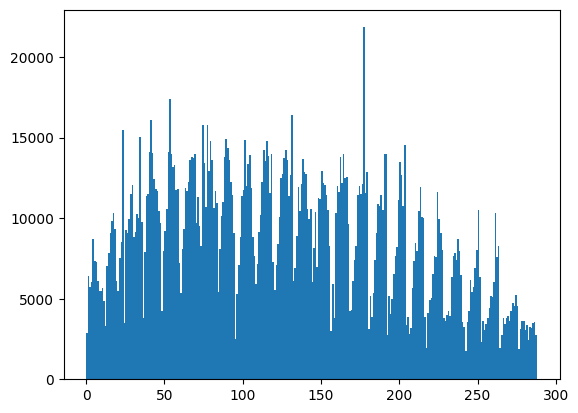

In [6]:
histogram_data = []

# Loop through each index of cblkid and nblk
for i in range(len(cblkid)):
    # Take the first nblk[i] elements from cblkid[i]
    if nblk_array[i] > 0:  # Ensure we're taking positive number of elements
        histogram_data.extend(cblkid[i][:nblk_array[i]]-1)

# Convert to numpy array for easier processing
histogram_data = np.array(histogram_data)

# Plot the histogram
d=plt.hist(histogram_data, bins=288,range=(0,288))

In [7]:
np.where(cblkid==0)

(array([     0,      0,      0, ..., 591173, 591174, 591175]),
 array([10, 11, 12, ..., 17, 17, 17]))

In [8]:
cblkid[224]

array([   95,    84,    72,   135,   136,    42,   108,     6,     9,
          52,   100,   149,   128,   200,   204,   180,   201, -1000,
       -1000, -1000, -1000, -1000, -1000, -1000, -1000])

In [9]:
13

13

In [10]:
cblkid[13]

array([111, 112, 100,  99, 125,  88, 126, 186,  58, 140, 189, 131, 119,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])

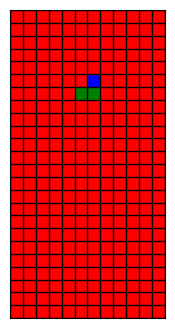

In [11]:
Grid(cblkid[event],nblk_array[event])

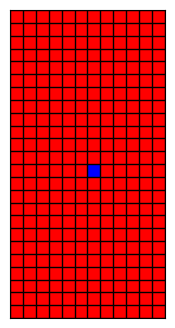

In [12]:
Grid([150],1)

# Look at Calibration Results

In [13]:
ADCAdjustment=np.load("ADCOffsetForOffset.npy")
HodoAdjustment=np.load("TDCOffsetHodo.npy")

In [14]:
def HCAL(config):
    rootfile = f"../outfiles/HCal_data_GEN3_sbs100p_nucleon_np_model1.root"
    #rootfile = f"../outfiles/oldhcal.root"
    rootfile2=f"../outfiles/HCal_data_GEN3_sbs100p_nucleon_p_model1.root"
    C = r.TChain("Tout")
    C.Add(rootfile)
    C.SetBranchStatus("*", 0)
   
    
    #HCAL VARS_____________________________________
    C.SetBranchStatus("cx", 1)
    C.SetBranchStatus("cy", 1)
    C.SetBranchStatus("cblktime",1)
    C.SetBranchStatus("cblkatime",1)
    C.SetBranchStatus("cblkid",1)
    C.SetBranchStatus("cblke",1)
    C.SetBranchStatus("tdc",1)
    C.SetBranchStatus("atime",1)
    C.SetBranchStatus("bbcal_time",1)
    C.SetBranchStatus("pblkid",1)
    C.SetBranchStatus("nclus",1)
    C.SetBranchStatus("nblk",1)
    C.SetBranchStatus("hodoTimes",1)
    C.SetBranchStatus("hodoIDs",1)
    C.SetBranchStatus("nbars",1)
    C.SetBranchStatus("hodoTOT",1)
    
    bbtime=array.array('d',[0])
    tdc=array.array('d',[0])
    atime=array.array('d',[0])
    pblkid=array.array('d',[0])
    cx = array.array('d', [0]*10) 
    cy = array.array('d', [0]*10) 
    cblktime=array.array('d',[0]*25)
    cblkatime=array.array('d',[0]*25)
    cblkid=array.array('d',[0]*25)
    cblke=array.array('d',[0]*25)
    nclus=array.array('d',[0])
    nblk=array.array('i',[0])
    hodoIDs=array.array('d',[0]*6)
    hodoTimes=array.array('d',[0]*6)
    hodoTOT=array.array('d',[0]*6)
    nbars=array.array('i',[0])
    
    C.SetBranchAddress("cx", cx)
    C.SetBranchAddress("cy", cy)
    C.SetBranchAddress("cblktime",cblktime)
    C.SetBranchAddress("cblkatime",cblkatime)
    C.SetBranchAddress("cblkid",cblkid)
    C.SetBranchAddress("cblke",cblke)
    C.SetBranchAddress("tdc",tdc)
    C.SetBranchAddress("atime",atime)
    C.SetBranchAddress("pblkid",pblkid)
    C.SetBranchAddress("bbcal_time",bbtime)
    C.SetBranchAddress("nclus",nclus)
    C.SetBranchAddress("nblk",nblk)
    C.SetBranchAddress("hodoIDs",hodoIDs)
    C.SetBranchAddress("hodoTimes",hodoTimes)
    C.SetBranchAddress("nbars",nbars)
    C.SetBranchAddress("hodoTOT",hodoTOT)

    #_____________________________________
    
    
    #CUT VARS_____________________________________
    C.SetBranchStatus("W2",1)
    C.SetBranchStatus("dx",1)
    C.SetBranchStatus("dy",1)
    
    W2=array.array('d',[0])
    dx=array.array('d',[0])
    dy=array.array('d',[0])
    
    C.SetBranchAddress("W2",W2)
    C.SetBranchAddress("dx",dx)
    C.SetBranchAddress("dy",dy)
    
    #_____________________________________
    
    cx_array=[]
    cy_array=[]
    cblktime_array=[]
    cblkatime_array=[]
    cblkid_array=[]
    cblke_array=[]
    tdc_array=[]
    bbtime_array=[]
    atime_array=[]
    new_atime_array=[]
    pblkid_array=[]
    target=[]
    nclus_array=[]
    nblk_array=[]
    hodoID_array=[]
    hodoTime_array=[]
    new_hodoTime_array=[]
    nbars_array=[]
    tot_array=[]

    #hodo_TOT_array=[]
    
    #tester=[]
    C.GetEntry(0)
    Entries=C.GetEntries()
    passedcut=0
    #Entries=4000000
    for i in range(0,Entries):
        
        C.GetEntry(i)
        #COOLPROGRESSTRACKER___________________________________________________________________________   
        if i % 10000 == 0 or i == Entries - 1:
            progress = f'Processing entry {i + 1}/{Entries} ({(i + 1) / Entries * 100:.2f}%)\r'
            sys.stdout.write(progress)
            sys.stdout.flush()
        #______________________________________________________________________________________________  

        #tester.append(list(cblkatime))
        #print(tester,'\n')  
        
        
        NBARS=nbars[0]
        TIMES=hodoTimes[:NBARS]
        IDS=hodoIDs[:NBARS]
        
        
        bar45= 45 in np.array(IDS).astype(int)
        block126= int(cblkid[0])==126
        #print(block126,cblkid[0])
        #cut----------------
        wcut=W2min<W2[0]<W2max
        dxcut=dxmin<dx[0]<dxmax
        dycut=dymin<dy[0]<dymax
        cut=bar45
        #cut = nblk[0]>1
        #-------------------
        EnergyOfCluster=np.sum(np.array(cblke[:nblk[0]]))
        #cut=EnergyOfCluster>.1
        if cut:
            if abs(cblkid[0])>500:
                continue
            
            #print(cblkid[0])
            
            
            
            #-----------------------------HODO TOT weighting with new offsets-----------------
            
            #bars in this cluster
            NBARS=nbars[0]
            TIMES=hodoTimes[:NBARS]
            IDS=hodoIDs[:NBARS]
            
            newTIMES=[]
            totweightedTIME=[]
            totweights=[]
            if NBARS <3:
                for i in range(0,NBARS):
                    #newTIMES.append(hodoTimes[i]+HodoAdjustment[int(hodoIDs[i])])
                    newTIMES.append(hodoTimes[i])
                for i in range(0,len(newTIMES)):
                    totweightedTIME.append(hodoTOT[i]*newTIMES[i])
                    totweights.append(hodoTOT[i])

                weightedHODOTIME=np.sum(newTIMES)/NBARS

                if len(totweights)==0:
                    continue
            else:
                continue
            #print(totweights)
            #-----------------------------------------------------------------------------------
            #-----------------------------------HCAL energy weighted time----------------------
            
            new_atime_array.append(atime[0]+ADCAdjustment[int(cblkid[0])-1])
            
            passedcut+=1
            cx_array.append(cx)
            cy_array.append(cy)
            tdc_array.append(tdc[0])
            bbtime_array.append(bbtime[0])
            atime_array.append(atime[0])
            for i in range(0,NBARS):
                tot_array.append(hodoTOT[i])
            new_hodoTime_array.append(np.sum(weightedHODOTIME))
            #new_hodoTime_array.append(hodoTimes[0]+HodoAdjustment[int(hodoIDs[0])])
            
            
            pblkid_array.append(pblkid[0])
            cblktime_array.append(list(cblktime))
            cblkatime_array.append(list(cblkatime))
            nclus_array.append(nclus[0])
            nblk_array.append(nblk[0])
            cblkid_array.append(list(cblkid))
            cblke_array.append(list(cblke))
            target.append(0)
            hodoTime_array.append(hodoTimes[0])
            hodoID_array.append(list(hodoIDs))
            nbars_array.append(nbars[0])
            
    return [tdc_array,bbtime_array,atime_array,cblkatime_array,new_atime_array,hodoTime_array,
            new_hodoTime_array,tot_array]




In [15]:
tdc_array,bbtime_array,atime_array,cblkatime_array,new_atime_array,hodoTime,new_hodoTime,tot_array=HCAL(config)

Error in <TList::Clear>: A list is accessing an object (0xb35f540) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0xb3236d0) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0xb323ab0) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0xb3b9fd0) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0xb3ba340) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0xb3ba6b0) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0xb3babe0) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0xb3bafa0) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0xb3bb900) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0xb3bbcf0) alread

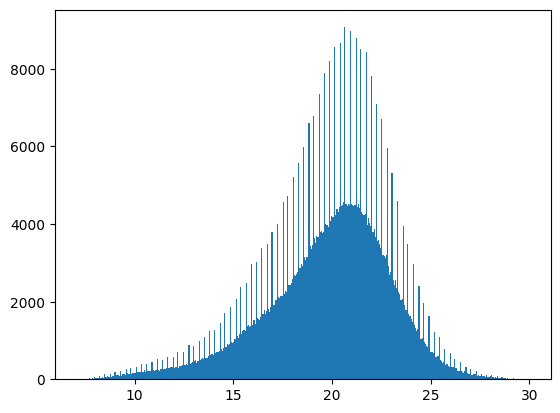

In [16]:
tothist=plt.hist(tot_array,bins=int(np.sqrt(len(tot_array))/2))

In [17]:
hodoTime[0]

-1.7462803811999996

In [18]:
new_hodoTime[0]

-2.1680491454000013

In [19]:
new_atime_array[0]

128.14486838958697

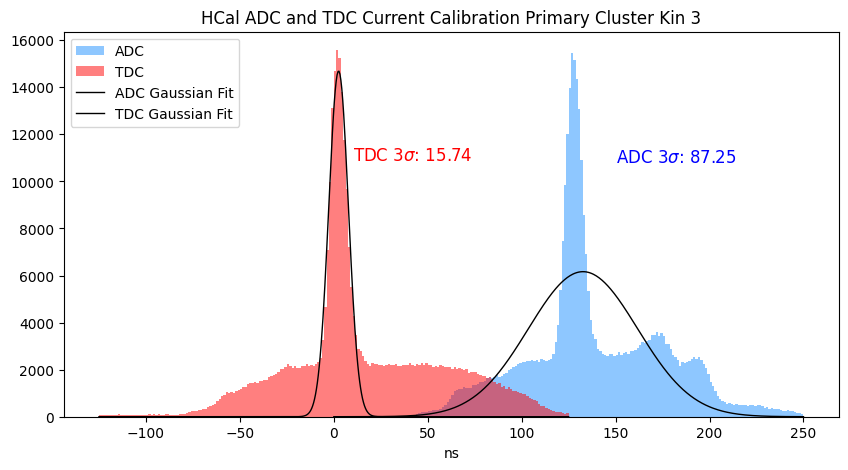

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from numpy.polynomial.polynomial import Polynomial

def gaussian(x, amp, mu, sigma):
    return amp * np.exp(-(x - mu)**2 / (2 * sigma**2))

def polynomial(x, a, b, c):
    return a * x**2 + b * x + c
plt.figure(figsize=(10,5))
adcHist = plt.hist(atime_array, bins=200, range=(0, 250), color='dodgerblue', alpha=0.5, label="ADC")
tdcHist = plt.hist(tdc_array, bins=200, range=(-125, 125), color='red', alpha=0.5, label="TDC")

adc_counts, adc_bins = adcHist[0], adcHist[1]
tdc_counts, tdc_bins = tdcHist[0], tdcHist[1]

adc_bin_centers = (adc_bins[:-1] + adc_bins[1:]) / 2
tdc_bin_centers = (tdc_bins[:-1] + tdc_bins[1:]) / 2

adc_initial_guess = [max(adc_counts), adc_bin_centers[np.argmax(adc_counts)], np.std(adc_array)]
popt_gauss_adc, _ = curve_fit(gaussian, adc_bin_centers, adc_counts, p0=adc_initial_guess)
popt_poly_adc, _ = curve_fit(polynomial, adc_bin_centers, adc_counts)

tdc_initial_guess = [max(tdc_counts), tdc_bin_centers[np.argmax(tdc_counts)], np.std(tdc_array)]
popt_gauss_tdc, _ = curve_fit(gaussian, tdc_bin_centers, tdc_counts, p0=tdc_initial_guess)
popt_poly_tdc, _ = curve_fit(polynomial, tdc_bin_centers, tdc_counts)

x_adc = np.linspace(0, 250, 500)
plt.plot(x_adc, gaussian(x_adc, *popt_gauss_adc), color='black', lw=1, label="ADC Gaussian Fit")

x_tdc = np.linspace(-125, 125, 500)
plt.plot(x_tdc, gaussian(x_tdc, *popt_gauss_tdc), color='black', lw=1, label="TDC Gaussian Fit")

plt.text(150, max(adc_counts)*0.7, f"ADC 3$\sigma$: {abs(3*popt_gauss_adc[2]):.2f}", color='blue', fontsize=12)
plt.text(10, max(tdc_counts)*0.7, f"TDC 3$\sigma$: {abs(3*popt_gauss_tdc[2]):.2f}", color='red', fontsize=12)

plt.title("HCal ADC and TDC Current Calibration Primary Cluster Kin 3")
plt.xlabel("ns")
plt.legend(loc="upper left")
plt.show()


Text(0.5, 0, 'ns')

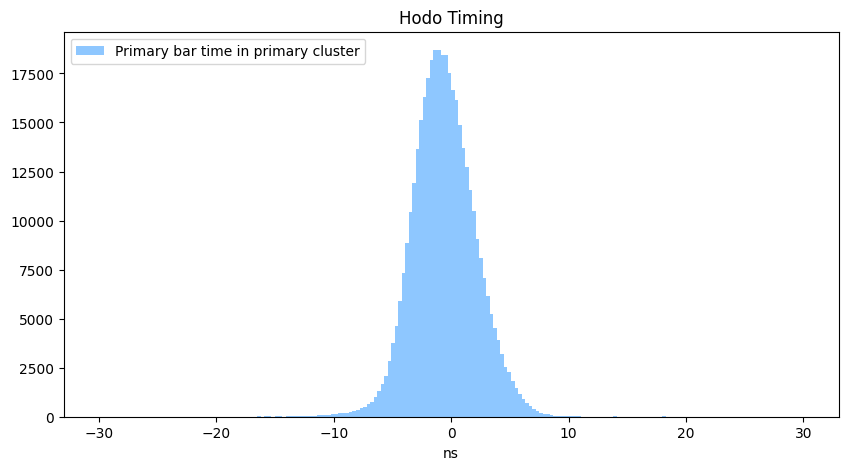

In [21]:
plt.figure(figsize=(10,5))
oldHodo = plt.hist(hodoTime, bins=200, range=(-30, 30), color='dodgerblue', alpha=0.5, label="Primary bar time in primary cluster")
#newHodo = plt.hist(new_hodoTime, bins=200, range=(-30, 30), color='red', alpha=0.5, label="Averaged Time for all bars in \n primary cluster")
plt.legend(loc='upper left')
plt.title("Hodo Timing")
plt.xlabel("ns")


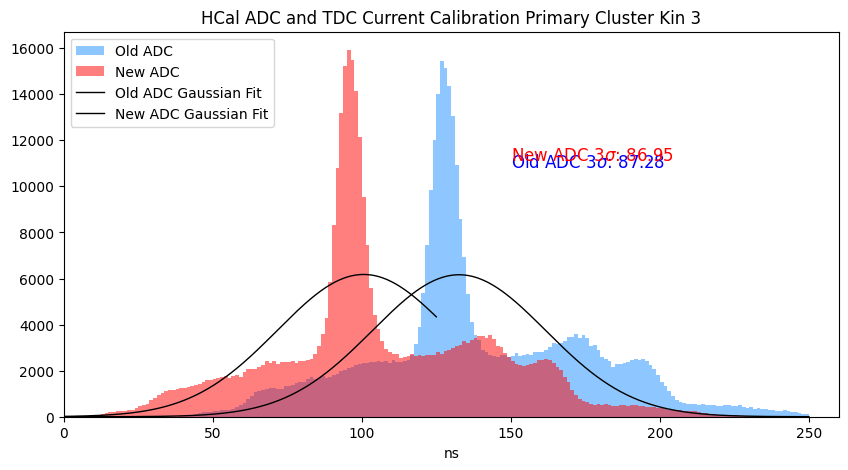

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from numpy.polynomial.polynomial import Polynomial

def gaussian(x, amp, mu, sigma):
    return amp * np.exp(-(x - mu)**2 / (2 * sigma**2))

def polynomial(x, a, b, c):
    return a * x**2 + b * x + c
newADC=np.array(new_atime_array)-35
plt.figure(figsize=(10,5))
adcHist = plt.hist(atime_array, bins=200, range=(0, 250), color='dodgerblue', alpha=0.5, label="Old ADC")
adcHistNew = plt.hist(newADC, bins=200, range=(0, 250), color='red', alpha=0.5, label="New ADC")

adc_counts, adc_bins = adcHist[0], adcHist[1]
adc_countsNew, adc_binsNew = adcHistNew[0], adcHistNew[1]

adc_bin_centers = (adc_bins[:-1] + adc_bins[1:]) / 2
adc_bin_centersNew = (adc_binsNew[:-1] + adc_binsNew[1:]) / 2


adc_initial_guess = [max(adc_counts), adc_bin_centers[np.argmax(adc_counts)], np.std(atime_array)]
popt_gauss_adc, _ = curve_fit(gaussian, adc_bin_centers, adc_counts, p0=adc_initial_guess)
popt_poly_adc, _ = curve_fit(polynomial, adc_bin_centers, adc_counts)

adc_initial_guessNew = [max(adc_countsNew), adc_bin_centersNew[np.argmax(adc_countsNew)], np.std(newADC)]
popt_gauss_adcNew, _ = curve_fit(gaussian, adc_bin_centersNew, adc_countsNew, p0=adc_initial_guessNew)
popt_poly_adcNew, _ = curve_fit(polynomial, adc_bin_centersNew, adc_countsNew)

x_adc = np.linspace(0, 250, 500)
plt.plot(x_adc, gaussian(x_adc, *popt_gauss_adc), color='black', lw=1, label="Old ADC Gaussian Fit")

x_adcNew = np.linspace(-125, 125, 500)
plt.plot(x_adcNew, gaussian(x_adcNew, *popt_gauss_adcNew), color='black', lw=1, label="New ADC Gaussian Fit")


plt.text(150, max(adc_counts)*0.7, f"Old ADC 3$\sigma$: {abs(3*popt_gauss_adc[2]):.2f}", color='blue', fontsize=12)
plt.text(150, max(adc_countsNew)*0.7, f"New ADC 3$\sigma$: {abs(3*popt_gauss_adcNew[2]):.2f}", color='red', fontsize=12)

plt.title("HCal ADC and TDC Current Calibration Primary Cluster Kin 3")
plt.xlabel("ns")
plt.legend(loc="upper left")
plt.xlim(0,260)
plt.show()


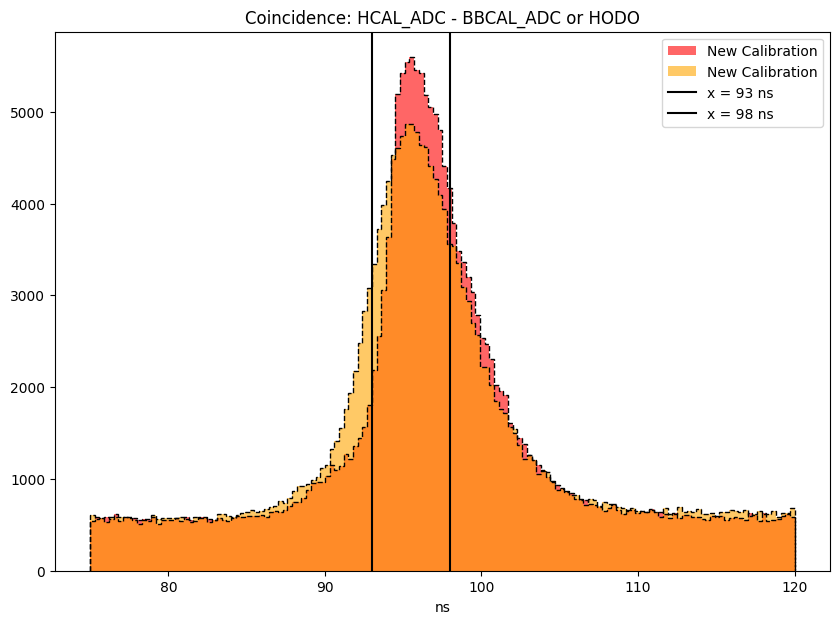

In [23]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
oldADC = np.array(atime_array)
newADC = np.array(new_atime_array)
newHODO=np.array(new_hodoTime)
oldTDC=np.array(tdc_array)
# Plotting the old calibration histogram
#plt.hist(oldADC - bbtime_array, range=(75, 120), bins=150, color='dodgerblue', alpha=0.6, label="Old Calibration", histtype='stepfilled')
#plt.hist(oldADC - bbtime_array, range=(75, 120), bins=150, color='black', linestyle='--', histtype='step')

# Plotting the new calibration histogram
plt.hist(newADC-133 - bbtime_array + 130, bins=150, range=(75, 120), color='red', alpha=0.6, label="New Calibration", histtype='stepfilled')
plt.hist(newADC-133 - bbtime_array + 130, bins=150, range=(75, 120), color='black', linestyle='--', histtype='step')

plt.hist(newADC-35- newHODO , bins=150, range=(75, 120), color='orange', alpha=0.6, label="New Calibration", histtype='stepfilled')
plt.hist(newADC-35- newHODO , bins=150, range=(75, 120), color='black', linestyle='--', histtype='step')

# Adding vertical lines at x = 93 and 97
plt.axvline(x=93, color='black', linestyle='-', label='x = 93 ns')
plt.axvline(x=98, color='black', linestyle='-', label='x = 98 ns')

plt.legend(loc='upper right')
plt.title("Coincidence: HCAL_ADC - BBCAL_ADC or HODO")
plt.xlabel("ns")

plt.show()


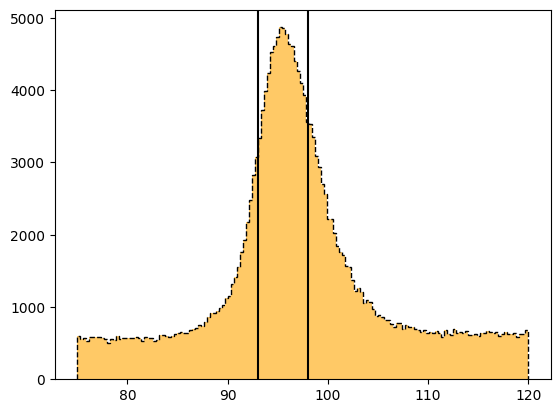

In [24]:
plt.hist(newADC-35- newHODO , bins=150, range=(75, 120), color='orange', alpha=0.6, label="New Calibration", histtype='stepfilled')
plt.hist(newADC-35- newHODO , bins=150, range=(75, 120), color='black', linestyle='--', histtype='step')
plt.axvline(x=93, color='black', linestyle='-', label='x = 93 ns')
plt.axvline(x=98, color='black', linestyle='-', label='x = 98 ns')

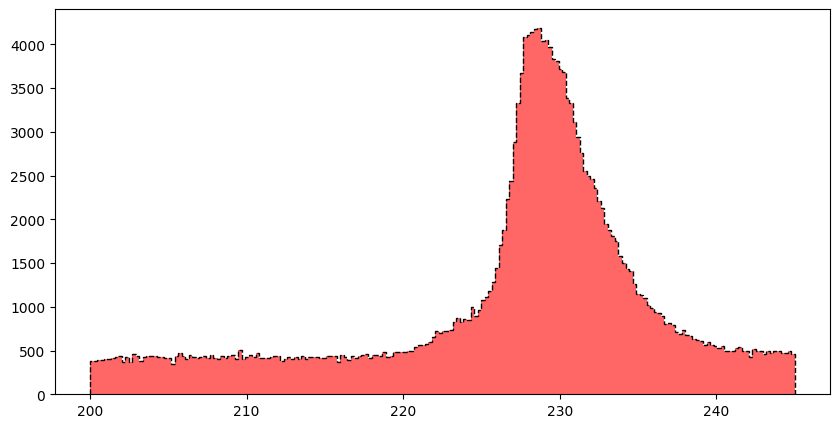

In [25]:
plt.figure(figsize=(10, 5))

newCoincidence = plt.hist(newADC - bbtime_array + 130, bins=200, range=(200, 245), color='red', alpha=0.6, label="New Calibration", histtype='stepfilled')
adsf=plt.hist(newADC - bbtime_array + 130, bins=200, range=(200, 245), color='black', linestyle='--', histtype='step')
